# Rounding tests

Testing analyses of rounded data

In [3]:
%config IPCompleter.use_jedi = False
import numpyro

numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive
from numpyro.contrib.funsor import config_enumerate

import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

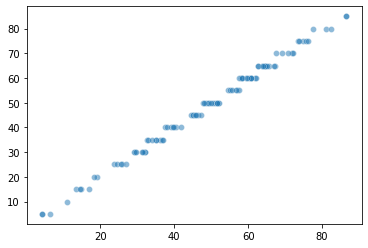

In [296]:
# first data that is all rounded to five

n_obs = 100
rg = default_rng(12345)

def round_to_one(x):
    return jnp.round(x,0)

def round_to_five(x):
    return jnp.round(x/5,0)*5

def round_to_twenty(x):
    return jnp.round(x/20,0)*20

x_true = rg.beta(3,3,n_obs)*100
x_obs = round_to_five(x_true)


sns.scatterplot(x_true, x_obs,alpha=.5)

In [264]:
# def beta_approx_cdf(mu, k, x):
#     # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
#     a = mu*k
#     b = (1-mu)*k
#     K_a = a
#     K_b = ((a-1)/(a*b-1)^(1/a))
    
#     return k_a, k_b

def beta_approx_cdf(a, b):
    # normal approximation, not great
    # mode K(a, b) = ((a – 1)/(ab – 1))1/a = mode beta(α, β) = (α – 1)/(α + β – 2).
    mu = a/(a+b)
    sigma = jnp.sqrt((a*b)/(jnp.power(a+b,2)*(a+b+1.)))
    
    return mu, sigma

def make_cuts(start, stop, step_size):
    return np.arange(start, stop, step_size)+step_size/2

def categorical_probs(a, b, step_size, max_size=100):
    
    cut_points = make_cuts(0, 100, step_size) # could maybe add one extra step_size unit on both ends then, but them off and normalize the middle?
    upper_pts = cut_points + step_size/2
    lower_pts = cut_points - step_size/2
    
    mu, sigma = beta_approx_cdf(a,b)
    prob_dist = dist.Normal(mu, sigma)
    probs = prob_dist.cdf(upper_pts/100.) - prob_dist.cdf(lower_pts/100.)
    return probs

def categorical_probs_spread(a, b, step_size, max_size=100):
    x = categorical_probs(a, b, step_size, max_size)
    
    return spread_vec(x, step_size)


def rounding_model(x_obs, step_size):
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))

    x_true_cp = categorical_probs_spread(mu*k, (1-mu)*k, step_size)

    with numpyro.plate("data", x_obs.shape[0]):
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs)
    
mcmc_test = MCMC(NUTS(rounding_model), 1000, 1000, num_chains=2)
mcmc_test.run(random.PRNGKey(0), x_obs, 5)    

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [265]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      5.35      0.91      5.32      3.92      6.93   1523.33      1.00
        mu      0.51      0.02      0.51      0.47      0.54   1663.42      1.00

Number of divergences: 0


Now to allow for different rounding policies and infer the rounding policy being used.

This code works (3/27/21, 4:29 PM)!

In [293]:

def rounding_mixture_model(x_obs):
    
    theta = numpyro.sample("theta", dist.Dirichlet(jnp.ones(3)))
    steps = jnp.array([1, 5, 20])
    
    mu = numpyro.sample("mu", dist.Beta(1,1))
    k = numpyro.sample("k", dist.HalfCauchy(10))
    theta_vec = jnp.reshape(theta, (-1,3))

    with numpyro.plate("data", x_obs.shape[0]):
        
        x_true_cp_stack = jnp.stack([ categorical_probs_spread(mu*k, (1.-mu)*k, step_size)  for step_size in steps])

        x_true_cp = jnp.matmul(theta_vec, x_true_cp_stack)
        numpyro.sample("x", dist.Categorical(x_true_cp), obs=x_obs) # need to spread the values instead of padding

In [297]:
mcmc_test = MCMC(NUTS(rounding_mixture_model), 1000, 1000, num_chains=1)
mcmc_test.run(random.PRNGKey(0), x_obs)   

sample: 100%|██████████| 2000/2000 [00:07<00:00, 276.45it/s, 7 steps of size 4.87e-01. acc. prob=0.92] 


In [298]:
mcmc_test.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      5.82      0.92      5.74      4.18      7.17   1047.60      1.00
        mu      0.51      0.02      0.51      0.48      0.54    976.21      1.00
  theta[0]      0.01      0.01      0.01      0.00      0.03   1028.28      1.00
  theta[1]      0.95      0.03      0.96      0.91      1.00    949.65      1.00
  theta[2]      0.04      0.03      0.03      0.00      0.08   1048.30      1.00

Number of divergences: 0
